In [1]:
from datasets import load_dataset
from transformers import ViTImageProcessor

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset('beans')

In [3]:
example = ds['train'][0]
example

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/89895646180044-config-parquet-and-info-beans-efae083d/downloads/extracted/308b715fb050ac3d5925e0741b3fc79e72b7c55de38b5cd598121a498db590ab/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

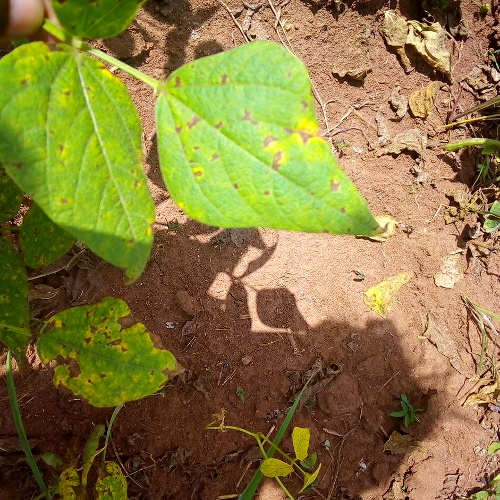

In [4]:
image = example['image']
image

In [5]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [6]:
# Use int2str to convert example image label int class to name
labels.int2str(example['labels'])

'angular_leaf_spot'

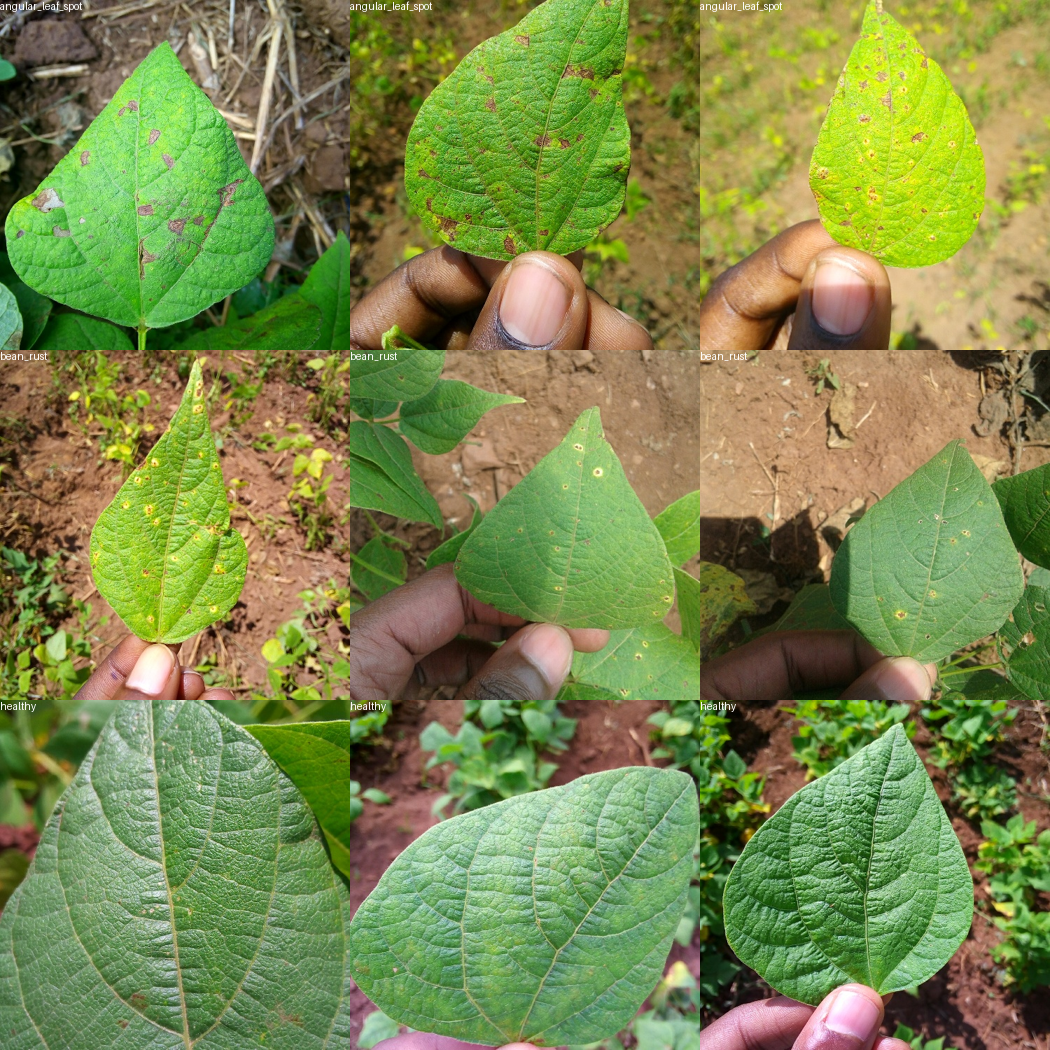

In [7]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [8]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [9]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [10]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

In [11]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [12]:
prepared_ds = ds.with_transform(transform)

In [13]:
## TUNING

In [14]:
import torch
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments
from transformers import ViTForImageClassification
from transformers import Trainer


In [15]:

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [16]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_351/3314281577.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [17]:

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

In [22]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1134
  train_runtime            =  0:00:48.17
  train_samples_per_second =      85.859
  train_steps_per_second   =       5.397


In [23]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0427
  eval_runtime            = 0:00:01.07
  eval_samples_per_second =    123.607
  eval_steps_per_second   =     15.799


In [24]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

In [25]:
trainer.create_model_card(**kwargs)

In [ ]:
model